In [1]:
# %%
import os
import math
import numpy as np
import torch
import torch.nn as nn
from transformer import Transformer
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from tqdm import tqdm

# %%
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device('mps')
# EXPERIMENT 1:
EMB_DIM = 128
N_LAYERS = 1
N_HEADS = 8
FORWARD_DIM = 512
DROPOUT = 0.05
LEARNING_RATE = 7e-4
BATCH_SIZE = 64
GRAD_CLIP = 1
MAX_LEN = 128 # ????

In [2]:
print(f"On {device}")

On cuda


In [3]:
# Task 0: DataLoader and Preprocessing
class TasksData(Dataset):
    def __init__(self, data_dir, file, transform=None):
        self.data_dir = data_dir
        self.file = file
        text_file = os.path.join(data_dir, file)

        data_dict = {"src": [], "tgt": []}

        with open(text_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                src = line.split('OUT:')[0]
                src = src.split('IN:')[1].strip()
                tgt = line.split('OUT:')[1].strip()

                data_dict['src'].append(src)
                data_dict['tgt'].append(tgt)

        self.data = pd.DataFrame(data_dict)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src = self.data['src'].iloc[idx] + ' <EOS>'
        tgt = '<SOS> ' + self.data['tgt'].iloc[idx] + ' <EOS>'
        return src, tgt

def create_vocab(dataset):
    vocab = set()

    for sample in dataset:
        vocab.update(sample.split())
    return vocab

# %%
# creating datasets
train_data = TasksData(data_dir='./data', file='tasks_train_simple.txt')
test_data = TasksData(data_dir='./data', file='tasks_test_simple.txt')

#creating source and target vocab
src_train_data = [src for src, tgt in train_data]
vocab_train_src = create_vocab(src_train_data)

tgt_train_data = [tgt for src, tgt in train_data]
vocab_train_tgt = create_vocab(tgt_train_data)

# we need to do word2idx to map the words to indexes. Bc the input for nn.Embedding has to be numbers
# since nn.Embdding has different weights in input andoutput embedding the same index will not be encoded to the same vector
word2idx_src = {w: idx + 1 for (idx, w) in enumerate(vocab_train_src)}
word2idx_src['<PAD>'] = 0

word2idx_tgt= {w: idx + 1 for (idx, w) in enumerate(vocab_train_tgt)}
word2idx_tgt['<PAD>'] = 0

# We need Vocabulary size without padding
# word2idx
# padding
#vocabulary and word2idx

def custom_collate_fn(batch):
    #input: batch of sentences
    # tokenize, word2idx, pad
    padded_src = pad_sequence([torch.tensor([word2idx_src[w] for w in src.split()]) for src, tgt in batch], batch_first=True, padding_value=0).to(device)
    padded_tgt = pad_sequence([torch.tensor([word2idx_tgt[w] for w in tgt.split()]) for src, tgt in batch], batch_first=True, padding_value=0).to(device)

    return padded_src, padded_tgt

# %%
# create dataloaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)

In [4]:
# define the model
model = Transformer(
    src_vocab_size=len(word2idx_src),
    tgt_vocab_size=len(word2idx_tgt),
    src_pad_idx=word2idx_src['<PAD>'],
    tgt_pad_idx=word2idx_tgt['<PAD>'],
    emb_dim=EMB_DIM,
    num_layers=N_LAYERS,
    num_heads=N_HEADS,
    forward_dim=FORWARD_DIM,
    dropout=DROPOUT,
    max_len=MAX_LEN,
).to(device)

Token Level Acc.

In [5]:
def token_lvl_accuracy(gt, pred):
    correct = 0
    i = 0

    # get start and end
    eos_idx = word2idx_tgt['<EOS>']
    sos_idx = word2idx_tgt['<SOS>']
    # print(eos_idx)
    # print(sos_idx)
    pred = pred[-1]
    gt = gt[-1]

    pred_start = (pred == sos_idx).nonzero(as_tuple=True)[0].item()
    pred_end = (pred == eos_idx).nonzero(as_tuple=True)[0].item()

    gt_start = (gt == sos_idx).nonzero(as_tuple=True)[0].item()
    gt_end = (gt == eos_idx).nonzero(as_tuple=True)[0].item()

    # slicing
    gt = gt[gt_start+1 : gt_end]
    pred = pred[pred_start+1 : pred_end]

    longer = gt if len(gt) > len(pred) else pred
    shorter = pred if len(gt) > len(pred) else gt

    longest_len = len(longer)

    shorter = torch.nn.functional.pad(shorter, (0, longest_len - len(shorter)), "constant", 0)

    correct = sum(longer == shorter)
    # print(longer)
    # print(shorter)
    # print(correct)
    return int(correct) / len(shorter) # same length as longer

## TRAINING

In [6]:
# model = Transformer(
#     src_vocab_size=len(word2idx_src),
#     tgt_vocab_size=len(word2idx_tgt),
#     src_pad_idx=word2idx_src['<PAD>'],
#     tgt_pad_idx=word2idx_tgt['<PAD>'],
#     emb_dim=EMB_DIM,
#     num_layers=N_LAYERS,
#     num_heads=N_HEADS,
#     forward_dim=FORWARD_DIM,
#     dropout=DROPOUT,
#     max_len=MAX_LEN,
# ).to(device)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx_tgt['<PAD>'])

# Training loop
num_epochs = 15
losses = []
accuraacy = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for step, (src, tgt) in (pbar := tqdm(enumerate(train_loader), total=len(train_loader))):
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()

        # output = model(src, tgt)
        output = model(src, tgt[:, :-1])
        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        tgt = tgt[:, 1:].contiguous().view(-1)

        loss = criterion(output, tgt)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)

        pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')

        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    losses.append(avg_epoch_loss)
checkpoint_path = f"transformer_exp1_15.pth"
torch.save(
    {'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, checkpoint_path)


  0%|          | 0/262 [00:00<?, ?it/s]c:\Users\magnu\UCPH\9-Semester\Advanced-Topics-in-Natural-Language-Processing\crispy-fortnight\transformer.py:187: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3701.)
  K_transposed = K.T.permute(3, 1, 0, 2)
Epoch [15/15], Loss: 0.0070: 100%|██████████| 262/262 [00:06<00:00, 41.48it/s]


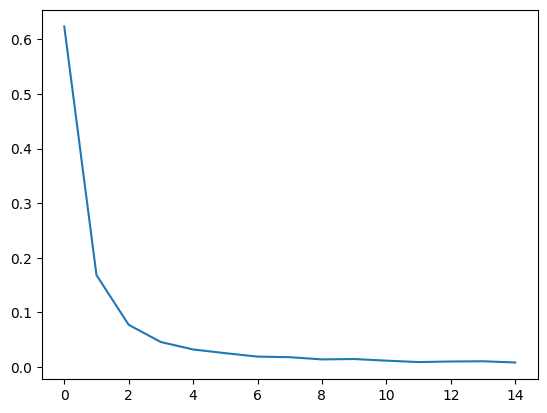

In [7]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(losses)

In [16]:
# Reverse the word-to-index mapping
idx2word_src = {idx: w for w, idx in word2idx_src.items()}
idx2word_tgt = {idx: w for w, idx in word2idx_tgt.items()}

def decode_indices(indices, idx2word):
    return ' '.join(idx2word[idx] for idx in indices if idx in idx2word and idx != word2idx_src['<PAD>'])

## TOKEN LEVEL ACC

## TESTING

In [ ]:
checkpoint_path = f"transformer_exp1_100.pth"
ckp = torch.load(checkpoint_path)
model.load_state_dict(ckp['model_state_dict'])
total_tokens = 0
correct_tokens = 0

def inference(input_seq: str):
    model.eval()
    pass

model.eval()

src, true_tgt = next(iter(test_loader))
print(src.shape)
src = src[0].unsqueeze(0).to(device)
true_tgt = true_tgt[0].unsqueeze(0).to(device)
# src, true_tgt = next(iter(test_loader))[0][0].unsqueeze(0).to(device)

print(src)
tgt = torch.tensor([[word2idx_tgt['<SOS>']]]).to(device)
# tgt = torch.tensor([[word2idx_tgt['<SOS>']]]).to(device)

# print(f'tgt {tgt.shape}')
# print(f'src {src.shape}')
iterations = 20
pred_sequence = [tgt.item()]
# print(pred_sequence)

for i in range(iterations):
    with torch.no_grad():
        # print(tgt)
        output = model.forward(src, tgt)
        predictions = nn.functional.softmax(output[:, -1, :], dim=-1)
        # print("argmax:", predictions.argmax(-1).shape)
        next_token = predictions.argmax(-1).item()


        # next_token_tensor = torch.tensor([[next_token]]).to(device)
        # tgt = torch.cat([tgt, next_token_tensor], dim=1)
        
        pred_sequence.append(next_token)
        tgt = torch.tensor(pred_sequence).unsqueeze(0).to(device)

        if next_token == word2idx_tgt['<EOS>']:
            break
        
        # print(tgt.shape)
        # print("tgt", tgt)

print(f'ground t: {true_tgt}')
print(f'predicted: {tgt}')
print(token_lvl_accuracy(true_tgt, tgt))


In [8]:
print(word2idx_tgt['<SOS>'])
print(word2idx_tgt['<EOS>'])

1
4


# BATCH INFERENCE

In [10]:
checkpoint_path = f"transformer_exp1_15.pth"
ckp = torch.load(checkpoint_path)
model.load_state_dict(ckp['model_state_dict'])
total_tokens = 0
correct_tokens = 0

src, tgt = next(iter(test_loader))
# print(src.shape, tgt.shape)
avg = []

# l = 0

for src_batch, tgt_batch in test_loader:
    # if l > 5:
    #     break
    for src, tgt in zip(src_batch, tgt_batch):
        # print(src)
        # 
        src = src.unsqueeze(0).to(device)
        true_tgt = tgt.unsqueeze(0).to(device)
        tgt = torch.tensor([[word2idx_tgt['<SOS>']]]).to(device)
        
        iterations = MAX_LEN
        pred_sequence = [tgt.item()]
        # print(tgt.shape)
        # print(src.shape, true_tgt.shape)

        for i in range(iterations):
            with torch.no_grad():
                output = model.forward(src, tgt)
                predictions = nn.functional.softmax(output[:, -1, :], dim=-1)
                next_token = predictions.argmax(-1).item()

                pred_sequence.append(next_token)
                tgt = torch.tensor(pred_sequence).unsqueeze(0).to(device)
                
                # Stop if end of sequence
                if next_token == word2idx_tgt['<EOS>']:
                    break

        m = token_lvl_accuracy(true_tgt, tgt)
        avg.append(m)
        # print(f'ground t: {true_tgt}')
        # print(f'predicted: {tgt}')
        # print(m)
        # print()
    # l += 1
    
print(sum(avg)/len(avg))
        

C:\Users\magnu\AppData\Local\Temp\ipykernel_11892\3057734478.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckp = torch.load(checkpoint_path)


0.9911292819381053
